In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from config import settings
from google.cloud import bigquery

In [21]:
def dados():
    project_id = settings.BQ_PROJECT_ID
    dataset_id = settings.BQ_DATASET_ID
    table_id = settings.BQ_TABLE_ID
    symbol = settings.SYMBOLS[0]  # Assuming you want to fetch data for the first symbol
    credentials = settings.GOOGLE_CREDENTIALS

    client = bigquery.Client.from_service_account_json(credentials)

    query = f"""
    SELECT * 
    FROM `{project_id}.{dataset_id}.{table_id}`
    WHERE symbol = @symbol
    ORDER BY Date
    """

    job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("symbol", "STRING", symbol)
        ]
    )

    df = client.query(query, job_config=job_config).to_dataframe()
    print(df.head())
    print(f"✔ Data fetched for symbol: {symbol}")
    return df

# ========================
# 1. Função de sequência
# ========================
def create_sequences(df: pd.DataFrame, n_steps: int, target_col: str):
    X, y = [], []
    for i in range(len(df) - n_steps):
        X_seq = df.drop(columns=target_col).iloc[i:i+n_steps].values
        y_val = df.iloc[i+n_steps][target_col]
        X.append(X_seq)
        y.append(y_val)
    return np.array(X), np.array(y)

# ========================
# 2. Função do modelo
# ========================
def criar_modelo(units=50, dropout_rate=0.2, l2_reg=0.01,activation='tanh', learning_rate=0.001, n_steps=10, n_features=5):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation,
                   input_shape=(n_steps, n_features),
                   kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [38]:
df = dados()

c:\Users\willb\Documents\Projetos\fiap-4\model\venv\lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


        Date  AAPL_Open  AAPL_High   AAPL_Low  AAPL_Close  AAPL_Volume symbol
0 2018-01-02  39.933986  40.436212  39.722768   40.426823    102223600   AAPL
1 2018-01-03  40.490191  40.964255  40.356422   40.419785    118071600   AAPL
2 2018-01-04  40.492524  40.710783  40.384571   40.607521     89738400   AAPL
3 2018-01-05  40.703754  41.156695  40.612227   41.069862     94640000   AAPL
4 2018-01-08  40.917316  41.213018  40.818746   40.917316     82271200   AAPL
✔ Data fetched for symbol: AAPL


In [39]:
df = df.drop(columns=['Date', 'symbol'])  # Remove colunas não numéricas
target_col = 'AAPL_Close'
features = df.drop(columns=['AAPL_Close']).columns.tolist()

In [48]:

# Split treino/teste
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False, random_state=23)

In [49]:
# Escalando
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

train_scaled_df = pd.DataFrame(train_scaled, columns=df.columns)
test_scaled_df = pd.DataFrame(test_scaled, columns=df.columns)

In [50]:
# ========================
# 5. GridSearchCV Setup
# ========================
param_grid = {
    "model__units": [50, 100],
    "model__dropout_rate": [0.2, 0.3],
    "model__l2_reg": [0.001, 0.01],
    "model__activation": ["tanh", "relu"],
    "model__learning_rate": [0.001, 0.0005,0.0001],
    "model__n_steps": [5,10,15],  # Grid pode testar mais de um valor
    "model__n_features": [len(features)],
    "batch_size": [16],
    "epochs": [30],
    "verbose": [0]
}


In [51]:
# Precisamos gerar X, y para o GridSearch com um n_steps inicial
n_steps = 10
X_train_seq, y_train = create_sequences(train_scaled_df, n_steps, target_col)
X_test_seq, y_test = create_sequences(test_scaled_df, n_steps, target_col)


In [52]:
# ========================
# 6. Wrap com Scikeras
# ========================
regressor = KerasRegressor(model=criar_modelo)

grid = GridSearchCV(estimator=regressor,
                    param_grid=param_grid,
                    scoring='neg_mean_squared_error',
                    cv=15,
                    verbose=2,
                    n_jobs=-1)

In [53]:
# ========================
# 7. Treinamento
# ========================
grid.fit(X_train_seq, y_train)

print("\nMelhores hiperparâmetros encontrados:")
print(grid.best_params_)

Fitting 15 folds for each of 144 candidates, totalling 2160 fits


c:\Users\willb\Documents\Projetos\fiap-4\model\venv\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\willb\Documents\Projetos\fiap-4\model\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Melhores hiperparâmetros encontrados:
{'batch_size': 16, 'epochs': 30, 'model__activation': 'tanh', 'model__dropout_rate': 0.2, 'model__l2_reg': 0.001, 'model__learning_rate': 0.001, 'model__n_features': 4, 'model__n_steps': 5, 'model__units': 100, 'verbose': 0}


In [54]:

# ========================
# 8. Avaliação final
# ========================
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_seq)

# Desescalonando o target
close_index = df.columns.get_loc(target_col)
close_mean = scaler.mean_[close_index]
close_std = scaler.scale_[close_index]

y_pred_real = y_pred * close_std + close_mean
y_test_real = y_test * close_std + close_mean



In [55]:
# ========================
# 9. Métricas
# ========================
print("\nMétricas na base de teste:")
# Cálculo das métricas
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_real, y_pred_real)
mape = np.mean(np.abs((y_test_real - y_pred_real) / y_test_real)) * 100
r2 = r2_score(y_test_real, y_pred_real)

# Impressão dos resultados
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")


Métricas na base de teste:
MSE: 16.1684
RMSE: 4.0210
MAE: 3.0352
MAPE: 1.62%
R² Score: 0.9190


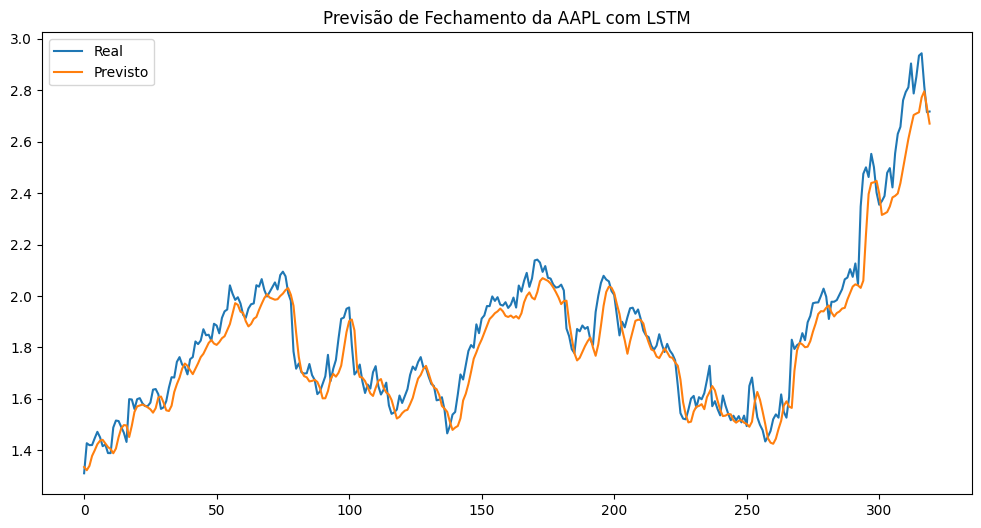

In [56]:
# Visualizar
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Real")
plt.plot(y_pred, label="Previsto")
plt.title("Previsão de Fechamento da AAPL com LSTM")
plt.legend()
plt.show()

In [57]:
import pickle

In [58]:
filename = 'best_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(grid, file)